<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/shine-on-you/HomeWork2_Regression%26Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашняя работа 2

## Регрессия

С 1-ого октября отменяется НДС на бриллианты, теперь они становятся новым инвестиционным инструментом. Давайте сделаем модель ценообразования для них.

Скачайте датасет diamonds.csv

В нем представлены характеристики бриллиантов и их цены с сайта jamesallen (B2C площадка) с 2022-07-01

**Описание полей**


* fluor - флуорисценция (свойство камня светиться в ультрафиолетовых лучах)
* symmetry - показатель симметричности
* platform - название платформы, где был размещен камень
* quality_group - составной показатель из cut polish symmetry
* size_group - каратно весовая группа
* big_size_group - каратно-весовая группа
* shape - форма
* color - цвет
* clarity - чистота
* cut - качество огранки (может быть только у круглых камней)
* polish - полировка
* id - номер камня
* date - дата
* price - цена
* carat - кол-во карат
* tablepercent - размер площадки по отношению ширине
* price_per_carat - цена за карат
* z - длина (diameter)
* x - ширина
* depth_perc - отношение высоты к ширине
* y - высота



In [2]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder
#from sklearn.compose import make_column_transformer
from sklearn.ensemble import BaggingRegressor, StackingClassifier, BaggingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,\
mean_absolute_percentage_error, accuracy_score, precision_score, recall_score, \
f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder,\
Normalizer
from sklearn.svm import SVC


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')
#path = 'drive/MyDrive/'

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Dimildizio/DS_course/main/shine-on-you/diamonds.csv', index_col=0)
df.shape

(222222, 17)

## EDA

In [5]:
df[df['date']==0]

In [6]:
#print('number of duplicates:',df.duplicated(keep=False).sum() - df.shape[0])
#Удалим пусте значения (у них айди 0)
df1=df.copy()
df1=df1.drop(df1[df1.id == 0].index)
#поскольку у нас только одна платформа, нам этот параметр не нужен
df1=df1.drop('platform', axis = 1)
#заменим пустые значения в fluor для one-hot encoding. симметрия No
df1['fluor'].fillna('NONE', inplace=True)
#Удалим камни без огранки
df1.dropna(subset = ['cut'], inplace=True)
#Удалим полные дубли
df1 = df1.drop_duplicates()

In [7]:
#Для ускорения манипуляций с датасетом переведем все в более "легкие" типы данных
for col in ['fluor', 'symmetry','shape', 'clarity', 'color', 'cut','polish']:
  df1[col] = df1[col].astype('category')
for col in ['id','date']:
  df1[col] = df1[col].astype('int32')
for col in ['price', 'carat','price_per_carat', 'z', 'x', 'y', 'depth_perc']:
  df1[col] = df1[col].astype('float32')

In [8]:
df1.describe().apply(lambda x: round(x,2))

,id,date,price,carat,price_per_carat,z,x,depth_perc,y
count,147594.00,147594.00,147594.00,147594.00,147594.00,147594.00,147594.00,147594.00,147594.00
mean,13649272.44,202206.03,11771.74,1.31,7492.82,6.68,6.65,63.98,4.24
std,2499814.34,0.82,24978.34,0.66,5388.50,0.91,0.93,4.03,0.53
min,19423.00,202205.00,920.00,0.81,1135.80,4.84,4.52,56.00,2.84
25%,13660021.00,202205.00,4690.00,1.00,4577.78,6.21,6.25,61.90,3.93
50%,14412989.00,202206.00,7180.00,1.01,6430.00,6.40,6.43,62.70,4.02
75%,14838204.75,202207.00,11720.00,1.50,9150.00,7.05,6.96,64.40,4.50
max,15418506.00,202207.00,2380380.00,21.17,955000.00,17.96,18.05,78.00,10.74


In [8]:
#Сколько уникальных значений в столбцах
for c in df1.columns:
  print(f'{c}: {df1[c].nunique()}')

Необходимо предсказать `price_per_carat`

### Задание 1: Очистка

Не все камни успевают продаться за один месяц, поэтому в таблице есть повторы. Объедините данные по одному камню: подумайте, как лучше это сделать, какую цену брать.

**Попробуйте найти аномалии:** вдруг цена на некоторые камни сильно меняется (то есть продавец сам не знает, по какой цене их продавать). Также убедитесь, что остальные параметры камня не меняются.

In [9]:
# разделите выборку на две части
id_stat = df1.groupby(by='id')['id'].count().to_frame().rename({'id':'occurrence'},axis=1) #Посчитайте статистику по кол-ву камней

one = id_stat[id_stat['occurrence'].isin([1])].index       # те камни, которые встречались один раз
three = id_stat[id_stat['occurrence'].isin([2,3])].index   # те камни, которые встречались 2 или 3 раза

In [11]:
num_more_than_three = df1.shape[0] - (df1[df1['id'].isin(one)].shape[0] + df1[df1['id'].isin(three)].shape[0])

In [10]:
df_one = df1[df1['id'].isin(one)]
df_three = df1[df1['id'].isin(three)]

df_three

,fluor,symmetry,shape,color,clarity,cut,polish,id,date,price,carat,price_per_carat,z,x,depth_perc,y
48477,MED,EX,RD,H,VVS2,EX,EX,11725253,202207,7510.0,1.02,7362.750000,6.41,6.45,62.500000,4.03125
235781,NONE,EX,RD,E,VS2,EX,EX,14438434,202207,8660.0,1.00,8660.000000,6.39,6.44,61.400002,3.95416
277744,NONE,VG,RD,F,VS1,VG,EX,14615276,202206,8480.0,1.00,8480.000000,6.28,6.36,62.299999,3.96228
143407,FNT,EX,RD,J,VVS1,EX,EX,13945129,202205,12120.0,1.50,8080.000000,7.38,7.41,60.000000,4.44600
10333,NONE,VG,RD,D,VS2,EX,VG,4666424,202207,19150.0,1.51,12682.120117,7.31,7.27,62.400002,4.53648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229133,NONE,EX,RD,I,SI2,EX,EX,14409793,202205,3330.0,0.90,3700.000000,6.13,6.18,62.000000,3.83160
268649,FNT,VG,RD,K,VS1,VG,EX,14581367,202205,3840.0,1.01,3801.979980,6.27,6.33,63.000000,3.98790
20595,NONE,EX,RD,D,VS2,EX,EX,7535786,202207,8700.0,0.97,8969.070312,6.36,6.32,62.200001,3.93104
282754,NONE,EX,RD,D,VS2,EX,EX,14631732,202206,6650.0,0.90,7388.890137,6.13,6.18,61.700001,3.81306


In [11]:
stat = df_three.groupby('id')['price', 'carat', 'price_per_carat','depth_perc', 'x','y','z'].agg(np.std)
stat.sort_values(by='depth_perc', ascending = False)
#stat[stat['depth_perc'] < 0.5]

<ipython-input-11-3915861bee5a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stat = df_three.groupby('id')['price', 'carat', 'price_per_carat','depth_perc', 'x','y','z'].agg(np.std)


,price,carat,price_per_carat,depth_perc,x,y,z
id,,,,,,,
14408689,106.066017,0.070711,582.182281,1.909189,0.056568,0.154128,0.035355
14020956,236.713610,0.034641,525.141101,1.039230,0.005774,0.069213,0.005774
14104780,777.817459,0.021213,487.599844,0.848529,0.028284,0.057502,0.028284
14579436,0.000000,0.000000,0.000000,0.707107,0.035355,0.072973,0.056568
14057291,0.000000,0.000000,0.000000,0.636397,0.000000,0.034620,0.000000
...,...,...,...,...,...,...,...
14580918,339.411255,0.000000,168.864212,0.000000,0.000000,0.000000,0.000000
13260650,56.568542,0.000000,62.161695,0.000000,0.000000,0.000000,0.000000
14580936,134.350288,0.000000,134.350288,0.000000,0.000000,0.000000,0.000000


In [14]:
for x in ['price', 'carat', 'price_per_carat', 'depth_perc', 'x','y','z']:
  print(f'std not null in {x}: {stat[stat[x] > 0].shape[0]}')

std not null in price: 28635
std not null in carat: 10
std not null in price_per_carat: 28638
std not null in depth_perc: 20391
std not null in x: 80
std not null in y: 20404
std not null in z: 82


In [12]:
df_three_2 = df_three.copy()
#странно что размер каменя изменился. Возможно другие измерения.поскольку x,y,z тоже изменяются
carat_to_drop = stat[stat['carat'] > 0]
df_three_2 = df_three_2[~df_three_2['id'].isin(carat_to_drop.index)]
#изменение в %_глубине тоже странное, сочтем выбросом все что выше 0.6 стд
depth_to_drop = stat[stat['depth_perc'] > 0.6]
df_three_2 = df_three_2[~df_three_2['id'].isin(depth_to_drop.index)]
#сколько % датасета мы убрали
print(f"removed: {round(1-df_three_2.sort_values(by='id').shape[0] / df_three.shape[0],3)*100}% of dataset")
#check how many dups 
print(f"No dups values: {df_three_2.shape[0] - df_three_2.sort_values(by = 'date').drop_duplicates(subset = ['id'], keep='last').shape[0]}")
#filter values
latest_idx = df_three_2.groupby('id')['date'].idxmax()
#check if equal to dups
print(f"Cut values: {df_three_2.shape[0] - df_three_2.loc[latest_idx].shape[0]}")
#take the latest date
df_three_2 = df_three_2.loc[latest_idx]

removed: 5.0% of dataset
No dups values: 36243
Cut values: 36243


In [50]:
#Соберем датасет, с обрезанием выбросов по iqr*1.5
def iqr_cut(mydf, cols):
  df_to_cut = mydf.copy()
  for col in cols:
    desc = df_to_cut[col].describe()
    irq = desc['mean'] + (desc['75%']-desc['25%']) *1.5
    df_to_cut = df_to_cut[df_to_cut[col] <= irq]
  return df_to_cut


df2 = pd.concat([df_one, df_three_2]).reset_index(drop=True)
df3 = iqr_cut(df2, ['price','carat','price_per_carat'])

In [1]:
#Отрисуем визуализацию
'''check_df = df2.copy()
for x in ['price', 'carat', 'price_per_carat', 'depth_perc', 'x','y','z']:
  print('Current column:', x)
  print(check_df[x].describe().apply(lambda x: round(x,2)))
  plt.boxplot(check_df[x])
  plt.show()
'''

"check_df = df2.copy()\nfor x in ['price', 'carat', 'price_per_carat', 'depth_perc', 'x','y','z']:\n  print('Current column:', x)\n  print(check_df[x].describe().apply(lambda x: round(x,2)))\n  plt.boxplot(check_df[x])\n  plt.show()\n"

In [19]:
#df2.hist(bins=50,figsize=(20,10))
#plt.show()

In [20]:
#sns.pairplot(df2, diag_kind = 'kde')

In [21]:
#plt.figure(figsize = (30,20))
#sns.heatmap(df3.corr(),annot = True , cmap = 'coolwarm' )

Видим корреляцию цены с размером камня и (ествественно) ценой за карат. чуть слабее крреляцию по размерам x,y,z.
С ОНЕ появляется много новых столбцов и парочка из них (естественно) колинеарны, поскольку это классы одного столбца. 
Но обрезать пока мы их не будем. 

Цены на бриллианты достаточно сильно меняются, попробуйте вычислить коэффициент инфляции и привести цены к последнему месяцу. Стоит учесть, что цены на все бриллианты не изменяются синхронно, то есть изменение в определенных группах может быть разным.

*Определите эти группы и рассчитайте коэффициенты инфляции для каждой из них. Подправьте цены на эти коэффициенты и создайте новую переменную.*

### Задание 2: Модель

Определите функцию потерь (MSE или MAE) и аргументируйте выбор.
Попробуйте сделать baseline.
Используйте LableEncoder для категориальных фичей и **постройте линейную модель**.

In [105]:
to_encode = ['fluor','symmetry',	'shape',	'color',	'clarity',	'polish', 'cut']

def label_encode_me(df2, to_encode):
  df3=df2.copy()
  le = LabelEncoder()
  df3[to_encode] = df3[to_encode].apply(le.fit_transform)
  return df3

def target_encode_me(df2, to_encode):
  df3=df2.copy()
  te = TargetEncoder(cols = to_encode)
  te.fit(df3[to_encode], df3['price_per_carat'])
  df3[to_encode] = te.transform(df[to_encode])
  df3 = df3.fillna(0)#dropna(subset = to_encode)
  print(df3.shape)
  return df3

def encode_me(df2, to_encode):
  df3 = df2.copy()
  df3 = pd.get_dummies(data=df3, columns=to_encode)
  return df3

На удивление, в target_encode_me заполнение НаНов нулями дает примерно такой же результат линрегрессии что и дроп рядов с НаНами

In [15]:
def get_inf(df3):
  categories = ['carat'] #определите по каким группам отпределять инфляцию (к примеру можно добавить каратную группу)

  df_index = df3.groupby(['date'] + categories)[['price_per_carat']]\
              .mean()\
              .reset_index() # индекс цен

  date_max = df_index.date.max()

  df_index = df_index.merge(df_index.query('date == @date_max')[categories + ['price_per_carat']]\
                            .rename(columns={'price_per_carat': 'price_per_carat_max'}), 
                            on=categories, how='outer') # сопоставляем группы с максимальной датой
  df_index
  df_index['inflation'] = df_index['price_per_carat_max'] / df_index.price_per_carat # вычисляем инфляцию

  df_with_inf = df3.merge(df_index[['date'] + categories + ['inflation']], 
                          on=['date'] + categories, how='left') # соединяем все в одной таблице

  df_with_inf = df_with_inf.dropna(subset=['inflation']).sort_values(by='inflation')#[df_with_inf['inflation']>=0]

  return df_with_inf
  #df_with_inf#[df_with_inf['id']==14652500]['inflation']

In [16]:
def get_all_combs(ilist):
  combinations = list((itertools.product(ilist, repeat=len(ilist))))
  no_dups = set([tuple(set(x)) for x in combinations])
  return no_dups

In [112]:


my_list = ['carat', 'price', 'depth_perc', 'x','y','z']


def my_linear(dataset, comb_cols = my_list):
# Generate all possible combinations
  min_val = 1000
  min_comb = ['price', 'price_per_carat']
  r2 = .5

  combinations = get_all_combs(comb_cols)
  for comb in combinations:
    #dataset = get_inf(my_dataset)
    cols_to_drop=list(comb)+['price_per_carat']

    y_valid, y_pred = my_model(dataset, cols_to_drop)

    r2_val = r2_score(y_valid, y_pred)  
    m = mean_absolute_error(y_valid, y_pred)

    if m <= min_val and r2_val >= r2:
      min_val = m
      min_comb = comb
      r2 = r2_val
      print("Mean squared error:", mean_squared_error(y_valid, y_pred))
      print("Mean absolute error:", mean_absolute_error(y_valid, y_pred))
      print("R-squared score:", r2_score(y_valid, y_pred))
      print()
  return(min_val, r2, min_comb, y_pred)
    

def my_model(dataset, cols_to_drop):
  X = dataset.drop(columns=cols_to_drop)
  y = dataset["price_per_carat"]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

  scaler = StandardScaler() # Помните, что на тесте делаем только transform
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  #model_LR = LinearRegression()
  model_LR = BaggingRegressor(estimator=LinearRegression(), n_estimators=5, random_state=42)

  model_LR.fit(X_train, y_train)

  y_pred = model_LR.predict(X_test)
  return y_test, y_pred



Проверим разные комбинации чисельных признаков. Стоит отметить, что если бы мы не сделали обрезку выбросов по IQR*1.5 то качество модели было бы хуже

In [111]:

df4 = encode_me(df3, to_encode)
my_inf = get_inf(df4)
min_mae, min_r, min_col, y_pred = my_linear(my_inf)             
print(f'mae: {min_mae}\nr2: {min_r}\ncolumns to drop: {min_col}')


Mean squared error: 832836.5591405329
Mean absolute error: 711.0229942121255
R-squared score: 0.8464268938192672

Mean squared error: 250068.54680551778
Mean absolute error: 390.3638214745777
R-squared score: 0.9538879470773267

Mean squared error: 144293.92891887148
Mean absolute error: 282.84015382644225
R-squared score: 0.9733925382791058

Mean squared error: 114238.1108669846
Mean absolute error: 243.4287252182153
R-squared score: 0.978934760563145

mae: 243.4287252182153
r2: 0.978934760563145
columns to drop: ('z',)


Итак мы узнали, что на нашем датасете, наиболее точные предсказания дает регрессия, которая отбрасывает лишь столбец "z".

In [119]:
def encode_and_run(my_df, encoder, name):
  print('Encoded using', name)
  df4 = encoder(my_df, to_encode)
  my_inf = get_inf(df4)
  y_test, y_pred = my_model(my_inf, ['z','price_per_carat'])

  print("Mean squared error:", round(mean_squared_error(y_test, y_pred), 2))
  print("Mean absolute error:", round(mean_absolute_error(y_test, y_pred), 2))
  print("R-squared score:", round(r2_score(y_test, y_pred), 2))
  print("MAPE: ", round(mean_absolute_percentage_error(y_test,y_pred), 2))
  print()


Теперь попробуйте OHE или TargetEncoder (сравните их).

Нормализуйте данные.

Поработайте с пропусками (обратите внимание на то, что у fluor возможен пропуск значения, а возможно отсутствие флуоресценции)

Покажите, насколько получилось улучшить результат.

In [113]:
text = ['LabelEncoder', 'OneHotEncoder', 'TargetEncoder']
encoders = [label_encode_me, encode_me, target_encode_me]
for j in range(len(text)):
  encode_and_run(df3, encoders[j], text[j])
  print()

Encoded using LabelEncoder
Mean squared error: 123766.70012625564
Mean absolute error: 251.01029139923043
R-squared score: 0.9771777110748556
MAPE:  0.04790642673713431


Encoded using OneHotEncoder
Mean squared error: 114238.1108669846
Mean absolute error: 243.4287252182153
R-squared score: 0.978934760563145
MAPE:  0.04631978339400159


Encoded using TargetEncoder
(83744, 16)
Mean squared error: 132850.91643040866
Mean absolute error: 258.68072259472933
R-squared score: 0.9755026029161958
MAPE:  0.04993891306774594




Как видим из кодировщиков лучше всего справился встроенный в pandas OHE - get_dummies. А TargetEncoder не сильно меняет стастику, даже если обрезать датасет еще в два раза, дропая НаНы.

In [120]:
dfs = [df.drop('platform',axis=1),df1,df2,df3]
dfs_desc = ['no preprocessing', 'drop duplicates and uncut gems', 'drop dups, uncut, old dates', 'drop dups, uncut, old and outliers']

for i in range(len(dfs)):
  print("Preprocessing:", dfs_desc[i])
  print('n_cols: ', dfs[i].shape[0])
  encode_and_run(dfs[i], encode_me, 'OHE')


Preprocessing: no preprocessing
n_cols:  222222
Encoded using OHE
Mean squared error: 4917236.37
Mean absolute error: 952.53
R-squared score: 0.81
MAPE:  0.16

Preprocessing: drop duplicates and uncut gems
n_cols:  147594
Encoded using OHE
Mean squared error: 10971473.17
Mean absolute error: 895.79
R-squared score: 0.5
MAPE:  0.14

Preprocessing: drop dups, uncut, old dates
n_cols:  107825
Encoded using OHE
Mean squared error: 2062875.95
Mean absolute error: 952.63
R-squared score: 0.91
MAPE:  0.16

Preprocessing: drop dups, uncut, old and outliers
n_cols:  83744
Encoded using OHE
Mean squared error: 114238.11
Mean absolute error: 243.43
R-squared score: 0.98
MAPE:  0.05



Стоит отметить, что регрессия работала на обрезанном датасете - около 80к из 222222 значений при обрезке IQR*1.5. Такая обрезка весьма сильно прорежает датасет и может изменить статистику, Линейная регрессия чувствительна к выбросам и на датасете с выбросами (удалены полные дубликаты и взяты лишь последние даты) показывает результат хуже по всем метрикам. На этом конкретном датасете мы в первую очередь смотрим на мае и r2 и как можно увидеть - разница мае 243 против 952 и r2 .98 против 81. Любопытно что при отбрасывании камней без информации об огранике r2 становится 0.5, а это подобно рандомноым угадываниям.

К тому же не проводился полный отсев по столбцам полученным через категориальное кодирование, поскольку колаб крашится от перегруза в цикле с подбором лучшего результата. 

In [84]:
#Так выглядят после обрезания датасеты
print(df.shape[0], df1.shape[0], df2.shape[0], df3.shape[0])

222222 147594 107825 83744


In [215]:
from typing import Tuple, List


def OHE(df: pd.DataFrame, columns: List[str]) -> Tuple[pd.DataFrame, List[str]]:
    """
    Вместо это функции можно использовать и функционал pandas
    """
    index = df.index
    one = OneHotEncoder(sparse=False, categories='auto')
    ohe = one.fit_transform(df[columns])
    col_names = one.get_feature_names(input_features = columns)
    df = df.drop(columns, axis=1)
    df = df.reset_index(drop=True)
    df = pd.concat([df, pd.DataFrame(ohe, columns=col_names)], axis = 1)
    df = df.set_index(index)
    return (df, col_names)


Сравните работу выбранной вами линейной модели с KNN

In [97]:
from sklearn.neighbors import KNeighborsRegressor

def KNNR(dataset, neighbours = 3, cols_to_drop = ['z','price_per_carat']):
  model = KNeighborsRegressor(n_neighbors=neighbours)

  X = dataset.drop(columns=cols_to_drop)
  y = dataset["price_per_carat"]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  
  print("Mean squared error:", mean_squared_error(y_test, y_pred))
  print("Mean absolute error:", mean_absolute_error(y_test, y_pred))
  print("R-squared score:", r2_score(y_test, y_pred))
  print("MAPE: ", mean_absolute_percentage_error(y_test,y_pred))

  

In [104]:
  df4 = encode_me(df3, to_encode)
  my_inf = get_inf(df4)
  my_neighbours = (3,4)
  for x in range(*my_neighbours):
    print('neighbours:',x)
    KNNR(my_inf, x)

neighbours: 3
Mean squared error: 308951.03
Mean absolute error: 383.69785
R-squared score: 0.9430301511449246
MAPE:  0.07555793


Эмпирическим методом проверяем что 3 соседа наиболее лучший вариант.
Как видим, КНН на том же датасете справляется немого хуже чем линейная регрессия и работат значительно медленнее.

## Классификация

Загрузите датасет bodyPerformance

Описание:

https://www.kaggle.com/datasets/kukuroo3/body-performance-data

In [224]:
#from google.colab import drive
#drive.mount('/content/drive')

#path = 'drive/MyDrive/'


Index(['gender', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic',
       'systolic', 'gripForce', 'sit and bend forward_cm', 'sit-ups counts',
       'broad jump_cm', 'class'],
      dtype='object')

In [189]:

dfc = pd.read_csv('https://raw.githubusercontent.com/Dimildizio/DS_course/main/shine-on-you/bodyPerformance.csv', index_col=0) #укажите свой путь
dfc = dfc[~dfc.duplicated()]

cat_cols =['gender', 'class'] 
for col in cat_cols:
  dfc[col] = dfc[col].astype('category')
for col in [x for x in dfc.columns if x not in cat_cols]:
  dfc[col] = dfc[col].astype('float32')

In [211]:
for col in [x for x in df.columns if x not in cat_cols]:
  print(col)

height_cm
weight_kg
body fat_%
diastolic
systolic
gripForce
sit and bend forward_cm
sit-ups counts
broad jump_cm


In [63]:
dfc['class'].unique()

['C', 'A', 'B', 'D']
Categories (4, object): ['A', 'B', 'C', 'D']

In [195]:
def iqr_minmax(mydf, cols):
  df_to_cut = mydf.copy()
  for col in cols:
    desc = df_to_cut[col].describe()
    irq_max = desc['mean'] + (desc['75%']-desc['25%']) *1.5
    irq_min = desc['mean'] - (desc['75%']-desc['25%']) *1.5
    df_to_cut = df_to_cut[df_to_cut[col] <= irq_max]
    df_to_cut = df_to_cut[df_to_cut[col] >= irq_min]
  return df_to_cut



<Axes: >

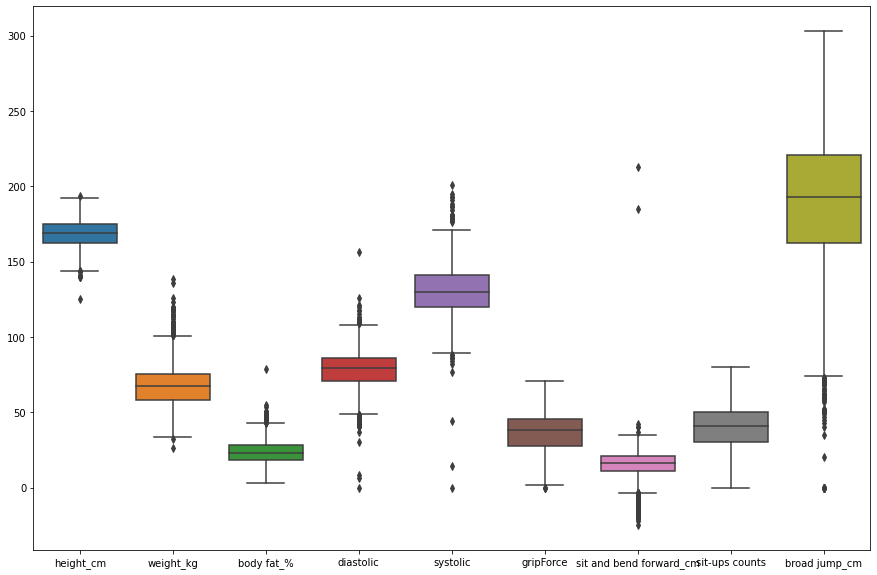

In [28]:
plt.figure(figsize=(15,10))
sns.boxplot(data=dfc)

(10858, 11)


<Axes: >

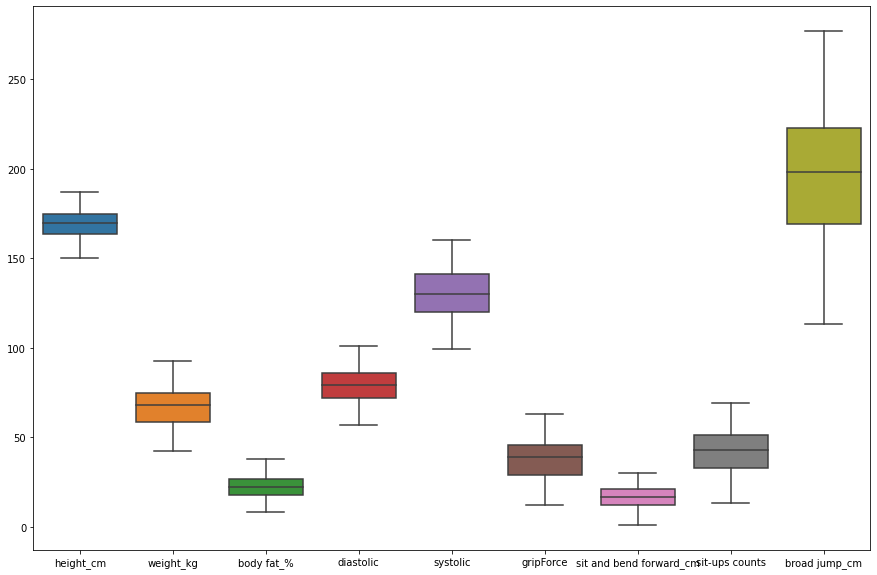

In [196]:
new_dfc = iqr_minmax(dfc, [x for x in dfc.columns if x not in cat_cols])
print(new_dfc.shape)
plt.figure(figsize=(15,10))
sns.boxplot(data=new_dfc)

Как видим аутлаеров незначительное количество, а обрезаться они не хотят ни кастомной функцией iqr*1.5 (максимумы не обрезаются, а минимумы слишком малы) ни стоковой по z-score


In [81]:
'''#без результата
from scipy import stats
z = np.abs(stats.zscore(dfc.drop(columns=['gender','class'], axis=1)))

dfc_o = dfc.copy()[(z < 3).all(axis=1)]
dfc_o.shape'''

"#без результата\nfrom scipy import stats\nz = np.abs(stats.zscore(dfc.drop(columns=['gender','class'], axis=1)))\n\ndfc_o = dfc.copy()[(z < 3).all(axis=1)]\ndfc_o.shape"

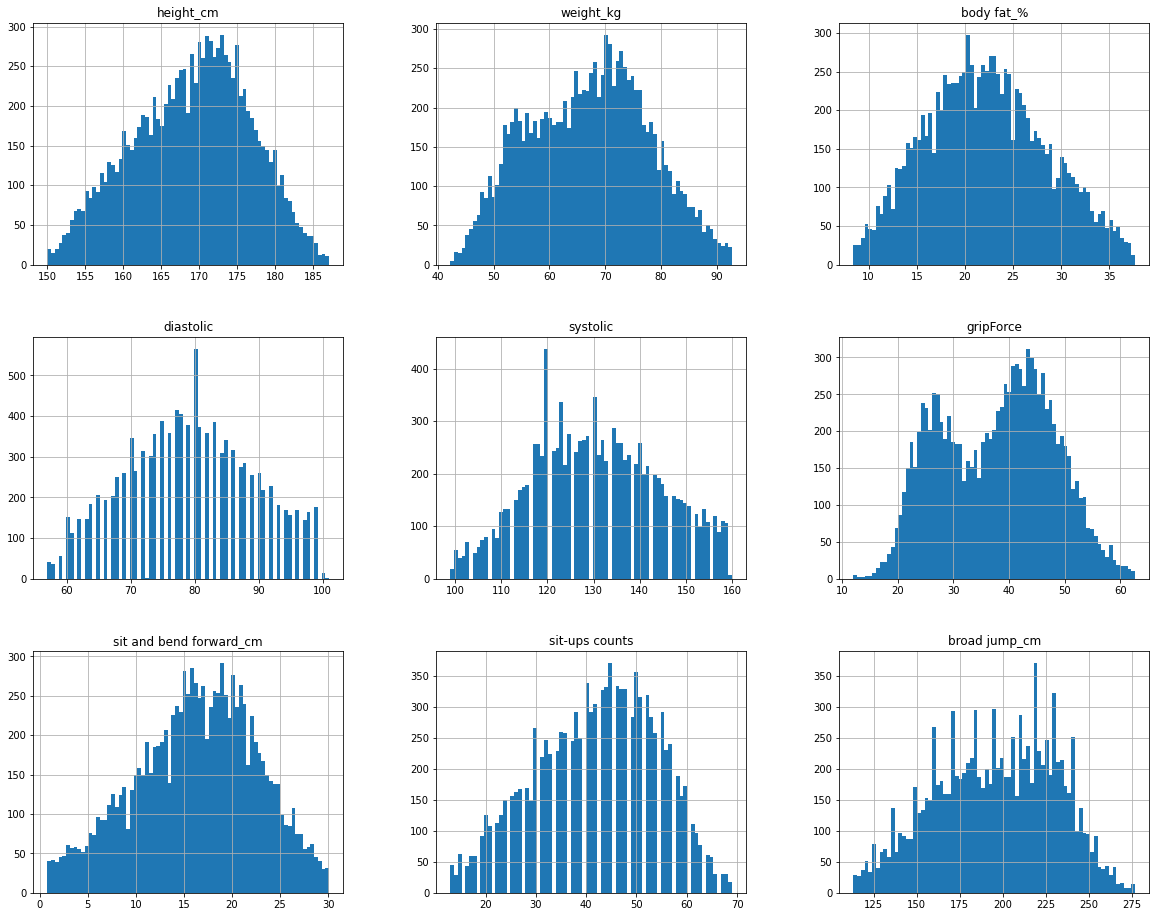

In [197]:
new_dfc.hist(bins=75, figsize=(20,16))
plt.show()

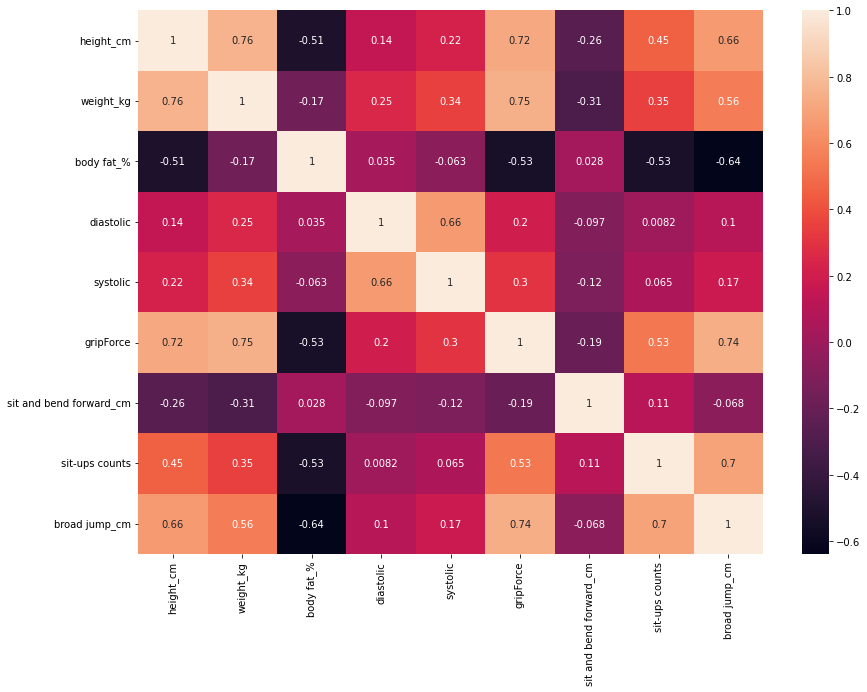

In [199]:
plt.figure(figsize = (14,10))
sns_plot=sns.heatmap(new_dfc.corr(),annot=True)
plt.show()

Максимальная зависимость наблюдается по росту к весу,  дальности прыжка и силе сжатия кисти и дальности прыжка к приседаниям. Ну двух видов давления.

### Задание 1: Определение гендера

Постройте модель, которая будет определять гендер.

Для этого определите две метрики качества, на которые вы будете смотреть. Аргументируйте свой выбор.

После чего преобразуйте категориальные переменные и постройте модель бинарной классификации на основе линейного классификатора и сравните с KNN.

P.S.: не забудте про нормализацию.

Поскольку сказано выбрать две, в качестве метрик были выбраны accuracy и f1. Первая по причине того, что классы мужчин и женщин для нас имеют одинаковое значение. А F1 была выбрана поскольку это среднее гармонично между precision и recall, таким образом мы и сумму всех правильно определенных положительных деленную на все положительно определенные (TP/(TP+FP)) учитываем и сумму всех правильно определенных положительных деленную на все истинные положительные значения (TP/ (TP+FN))

In [43]:
def class_model(dfc, model, target='gender', encode = ['class']):
  print(model)
  df=dfc.copy()
  df = df.reset_index()
  df = pd.get_dummies(dfc, columns=encode)

  X = df.drop(target, axis=1)
  y = df[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

  pipe = make_pipeline(StandardScaler(), Normalizer(), model)
  pipe.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = pipe.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  #precision = precision_score(y_test, y_pred, pos_label='M')
  #recall = recall_score(y_test, y_pred, pos_label='M')
  f1 = f1_score(y_test, y_pred, pos_label='M')
  
  print('Accuracy:', round(accuracy,4))
  #print('Precision:', round(precision,4))
  #print('Recall:', round(recall,4))
  print('F1:', round(f1,4))
  print()


In [204]:
class_model(dfc,LogisticRegression())
class_model(dfc,KNeighborsClassifier(n_neighbors=10))

LogisticRegression()
Accuracy: 0.9813
F1: 0.9852

KNeighborsClassifier(n_neighbors=10)
Accuracy: 0.9858
F1: 0.9887



Как видим, с бинарной классификацией оба классификатора справились отлично, КНН чуть лучше c пиковым значением 10 соседей (до и после - убывание). Но он и работает медленее. Любопытно, что на уменьшенном на 25% датасете с обрезанными аутлаерами результат на 0.002 хуже

### Задание 2: Определение класса

Теперь опробуем построить модель, которая будет предсказывать class физической формы.

Для этого определите метрики качества для задачи мультиклассификации (аргументируйте выбор).

Постройте модель мультиклассовой классификации на основе линейного классификатора и сравните с KNN.

In [288]:
#Didn't manage to make it work properly on mult
def rocauc(y_test, y_pred):
  le = LabelEncoder()
  y1=le.fit_transform(y_test.copy())
  y2=le.fit_transform(y_pred.copy())
  return roc_auc_score(y1,y2) 

In [96]:
from sklearn.metrics import classification_report


In [175]:

def class_model_2(dfc, model, target='gender', encode = ['class'], drop = []):
  print(model)
  df=dfc.copy()
  df = df.reset_index()
  df = pd.get_dummies(dfc, columns=encode)

  X = df.drop([target]+['class']+drop, axis=1)
  y = df['class']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

  pipe = make_pipeline(StandardScaler(), Normalizer(), model)
  pipe.fit(X_train, y_train)

  y_pred = pipe.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average = 'macro')
  f1 = f1_score(y_test, y_pred, average = 'micro')
  #roc_auc = rocauc(y_test, y_pred)
  
  print('Accuracy:', round(accuracy,4))
  print('Precision:', round(precision,4))
  print('Recall:', round(recall,4))
  print('F1:', round(f1,4))
  print()#'ROC_AUC:', roc_auc)

In [207]:
dfi = dfc.reset_index()
class_model_2(dfi, LogisticRegression(max_iter=5000), 'class', ['gender'], drop = ['systolic', 'height_cm'])
class_model_2(dfi, SVC(max_iter=5000), 'class', ['gender'], drop = ['systolic', 'height_cm'])
class_model_2(dfi, KNeighborsClassifier(n_neighbors=10), 'class', ['gender'],drop = ['systolic', 'height_cm'])

LogisticRegression(max_iter=5000)
Accuracy: 0.6222
Precision: 0.6144
Recall: 0.6222
F1: 0.6222

SVC(max_iter=5000)
Accuracy: 0.7118
Precision: 0.7186
Recall: 0.7118
F1: 0.7118

KNeighborsClassifier(n_neighbors=10)
Accuracy: 0.6532
Precision: 0.6635
Recall: 0.6532
F1: 0.6532



Любопытно, что не обрезанный от выбросов датасет на отдельных моделях классифицирует лучше, чем с обрезанием 130к до 100к на 10%-15%, но стеккинг улучшает продуктивность на 2% по сравннию с таким же стеком моделей, а беггинг - на 3% 

In [208]:
#Используем стекинг
estimators = [
     ('LogReg', LogisticRegression(max_iter=5000)),
     ('SVM', SVC(max_iter=5000)),
     ("KNN", KNeighborsClassifier(n_neighbors=3))]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=SVC(max_iter=5000))
class_model_2(new_dfc.reset_index(), stacking_model, 'class', ['gender'], drop = ['systolic', 'height_cm'])

StackingClassifier(estimators=[('LogReg', LogisticRegression(max_iter=5000)),
                               ('SVM', SVC(max_iter=5000)),
                               ('KNN', KNeighborsClassifier(n_neighbors=3))],
                   final_estimator=SVC(max_iter=5000))
Accuracy: 0.6657
Precision: 0.6729
Recall: 0.6567
F1: 0.6657



In [209]:
bag = BaggingClassifier(estimator=SVC(max_iter=5000), n_estimators=5, random_state=42)
class_model_2(new_dfc.reset_index(), bag, 'class', ['gender'], drop = ['systolic', 'height_cm'])

BaggingClassifier(estimator=SVC(max_iter=5000), n_estimators=5, random_state=42)
Accuracy: 0.6602
Precision: 0.6665
Recall: 0.6498
F1: 0.6602



Бейзлайн выдает около 62-71% по всем метрикам в лучшем случае - SVM. из всех параметров систоличествое давление стоит отбросить, поскольку без него все метрики лучше и незначительно отбрасывание роста имеет прирост в 0.004. Так же, несомненно важным фактором считается reset_index() который добавляет колонку возраста, которая прежде была индексом.
Что можно было бы еще сделать:
1. Провести нормальный EDA
2. Обрезка выбросов иным способом чем по iqr*1.5 
3. Классифиция с отбрасыванием различных комбинаций параметров, но тут колаб психует вылетает 
4. Любопытное наблюдение - несмотря на то, что SVM справляется лучше, при использовании бэггинга или стеккинга результат выходит хуже, хотя исходя из того что утверждалось на лекциях, хуже он быть не может. Возможно причина в очередности или нормализации.
5. без пайплайна с нормализацией и скейлингом линейная регрессия практически не меняется, а вот SVM теряет около 8% и скорость работы классификаторов значительно ухудшается